In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TO DO THIS, GO ON KAGGLE :https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

THEN DOWLOAD TO ZIP USINNG THE DOWLOAD BUTTON.

THEN ADD IT TO YOUR GOOGLE DRIVE AS A ZIP FILE.
THEN MYDIRVE/YOUR_NOTEBOOK/DATASET.ZIP


In [ ]:
!unzip "/content/drive/MyDrive/dst/archive.zip" -d "/content/data"



Archive:  /content/drive/MyDrive/dst/archive.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(21

In [ ]:
!ls /content/data


Testing  Training


Loaded image: /content/data/Training/meningioma_tumor/m1(39).jpg


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

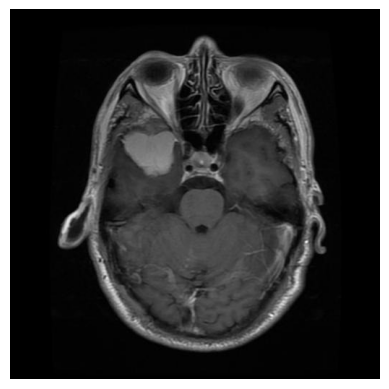

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


Dataset has now been loaded in. Now we need to transform the images by resizing and ToTensor and make dataloaders.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
train_dataset.classes


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])


(np.float64(-0.5), np.float64(1809.5), np.float64(453.5), np.float64(-0.5))

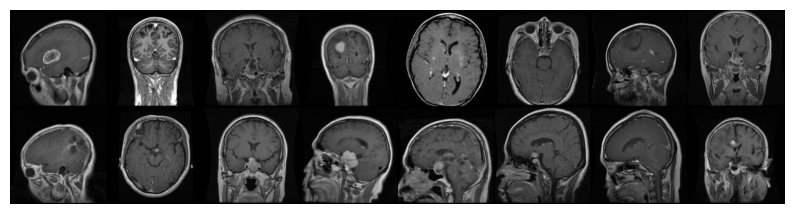

In [ ]:
import matplotlib.pyplot as plt
import torchvision

plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(images[:16]).permute(1,2,0))
plt.axis("off")


In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 224 → 112

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),     # 112 → 56
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 64),
            nn.ReLU(),
            nn.Linear(64, len(train_dataset.classes)),
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


In [ ]:
import torchvision.models as models
import torch.nn as nn

#model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
#model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))


Choose our device - CPU.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [ ]:
epochs = 10  # increase later

# Training the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total * 100
    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {running_loss:.4f}  Train Acc: {train_acc:.2f}%")


Epoch [1/10]  Loss: 97.0441  Train Acc: 53.24%
Epoch [2/10]  Loss: 72.0875  Train Acc: 66.55%
Epoch [3/10]  Loss: 58.8037  Train Acc: 73.62%
Epoch [4/10]  Loss: 48.6885  Train Acc: 78.95%
Epoch [5/10]  Loss: 42.0693  Train Acc: 82.30%
Epoch [6/10]  Loss: 38.2617  Train Acc: 83.87%
Epoch [7/10]  Loss: 33.0522  Train Acc: 86.66%
Epoch [8/10]  Loss: 30.3986  Train Acc: 87.35%
Epoch [9/10]  Loss: 27.7382  Train Acc: 88.26%
Epoch [10/10]  Loss: 26.9686  Train Acc: 88.54%


In [ ]:
torch.save(model.state_dict(), "simplecnn_mri.pth")
model.load_state_dict(torch.load("simplecnn_mri.pth", map_location=device))

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total * 100
print("Test Accuracy:", test_acc)


Test Accuracy: 58.88324873096447


**Vanilla Gradient**

The Vanilla Gradient is the most basic gradient-only pixel attribution method. It explains why the CNN made its classification by measuring how sensitive the predicted class is to each input pixel. In this project, we will be using saliency maps to visualise this: the brighter the pixel indicates the more important in the classification the pixel was.

To compute the Vanilla Gradient we perform a forward pass of an image, then compute the gradient of the predicted class score with respect to the input pixels.

Say our neural network is a function $f(x)=(f_1(x), f_2(x), \dots, f_K(x))$ where $f_i(x)$ is the pre-softmax logit for class $i$ and we have $K$ classes. Then the model will predict class $c$ such that

$c = argmax_{i \in \{1, \dots, K\}} f_i(x).$


To understand why the model chose c, we compute the gradient of the predicted class logit with respect to the input pixels:

$G(x) = \frac{\partial}{\partial x}f_c(x) \bigg|_{x=x_0}$

When interpreting these gradients, a large absoloute indicates that increasing this pixel increases the model's confidence, whilst a zero gradient indicates no useful effect. We are interested in supportive pixels regardless of direction, so we retain the absoloute value of the gradient.

The raw gradient has shape $(C,H,W)$ - no. channels (here red, green, blue), height, width - so we need to reduce the dimensionality to $(H,W)$ to display our 2D Saliency map, then normalise it to $[0,1]$.

$S_{\text{vanilla}}(i,j)=\max_{c \in \{1, \dots, K\}}\vert G(x)_{c,i,j}\vert$

Vanilla gradient isn't recognised as the most powerful pixel attribution measure (hence why we will try SmoothGrad and GradCAM) - it's highly sensitive to small changes in input and therefore vulnerable to noise. Additionally, its gradients can suddenly jump across classes at ReLU boundaries.

In [ ]:
import torch
import numpy as np

def compute_vanilla_saliency(model, image_tensor, target_class, device):
    """
    Compute vanilla gradient saliency map for a single input image.
    image_tensor: shape [1, C, H, W]
    """

    model.eval()
    image_tensor = image_tensor.clone().detach().to(device)
    image_tensor.requires_grad_(True)

    # Forward pass - computes f(x)
    output = model(image_tensor)
    score = output[0, target_class]

    # Backward pass - compute gradient at target_class
    model.zero_grad()
    score.backward()

    # Extract raw gradient wrt input
    grads = image_tensor.grad.detach().cpu().numpy()[0]  # (C,H,W)

    # Take absoloute value
    saliency = np.max(np.abs(grads), axis=0)

    # Normalise to [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency


SmoothGrad

SmoothGrad combats this sensitivity to noise by adding Gaussian noise $g_i$ to multiple versions of the image, then averaging over the ensemble's attribution maps. In essence, 'smoothing' out the high-frequency derivative fluctuations.

$g_i \sim \mathcal{N}(0, \sigma^2)$

Below, we will experiment with changing parameters noise variance and number of samples. The "ideal" noise level suggested by Smilkov et al is around 10-20% (as a proportion of the dynamic range of input features) and the ideal sample number is $n \approx 50$, as we tend to get diminishing results past that.


Theoretical Justification via Taylor Expansion

- use paper: https://www.emergentmind.com/topics/smoothgrad-technique and add maths section
- justify choices of hyperparameters

In [ ]:
def compute_smoothgrad(model, image_tensor, target_class, device,
                       n_samples=50, stdev=0.15, magnitude=True):
    """
    SmoothGrad implementation.
    Adds Gaussian noise to input and averages gradient saliency.
    """

    model.eval()

    # Convert input to numpy for noise sampling
    x_np = image_tensor.clone().detach().cpu().numpy()
    img_min, img_max = x_np.min(), x_np.max()
    noise_std = stdev * (img_max - img_min)

    total_gradients = np.zeros_like(x_np)

    for i in range(n_samples):

        # Add Gaussian noise
        noise = np.random.normal(0, noise_std, size=x_np.shape).astype(np.float32)
        noisy_input = x_np + noise

        noisy_tensor = torch.from_numpy(noisy_input).to(device)
        noisy_tensor.requires_grad_(True)

        # Forward
        output = model(noisy_tensor)
        score = output[0, target_class]

        # Backward
        model.zero_grad()
        score.backward()

        grads = noisy_tensor.grad.detach().cpu().numpy()

        # Accumulate gradients
        if magnitude:
            total_gradients += grads * grads
        else:
            total_gradients += np.abs(grads)

    # Average
    avg_grad = total_gradients[0] / n_samples  # remove batch dim
    saliency = np.max(avg_grad, axis=0)

    # Normalise [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency

The importance of $\sigma $:

When we add Gaussian noise to each pixel realisation $x$, we add it by:

$x_i = x + \epsilon_i,      $ where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$.




[299, 88, 251]


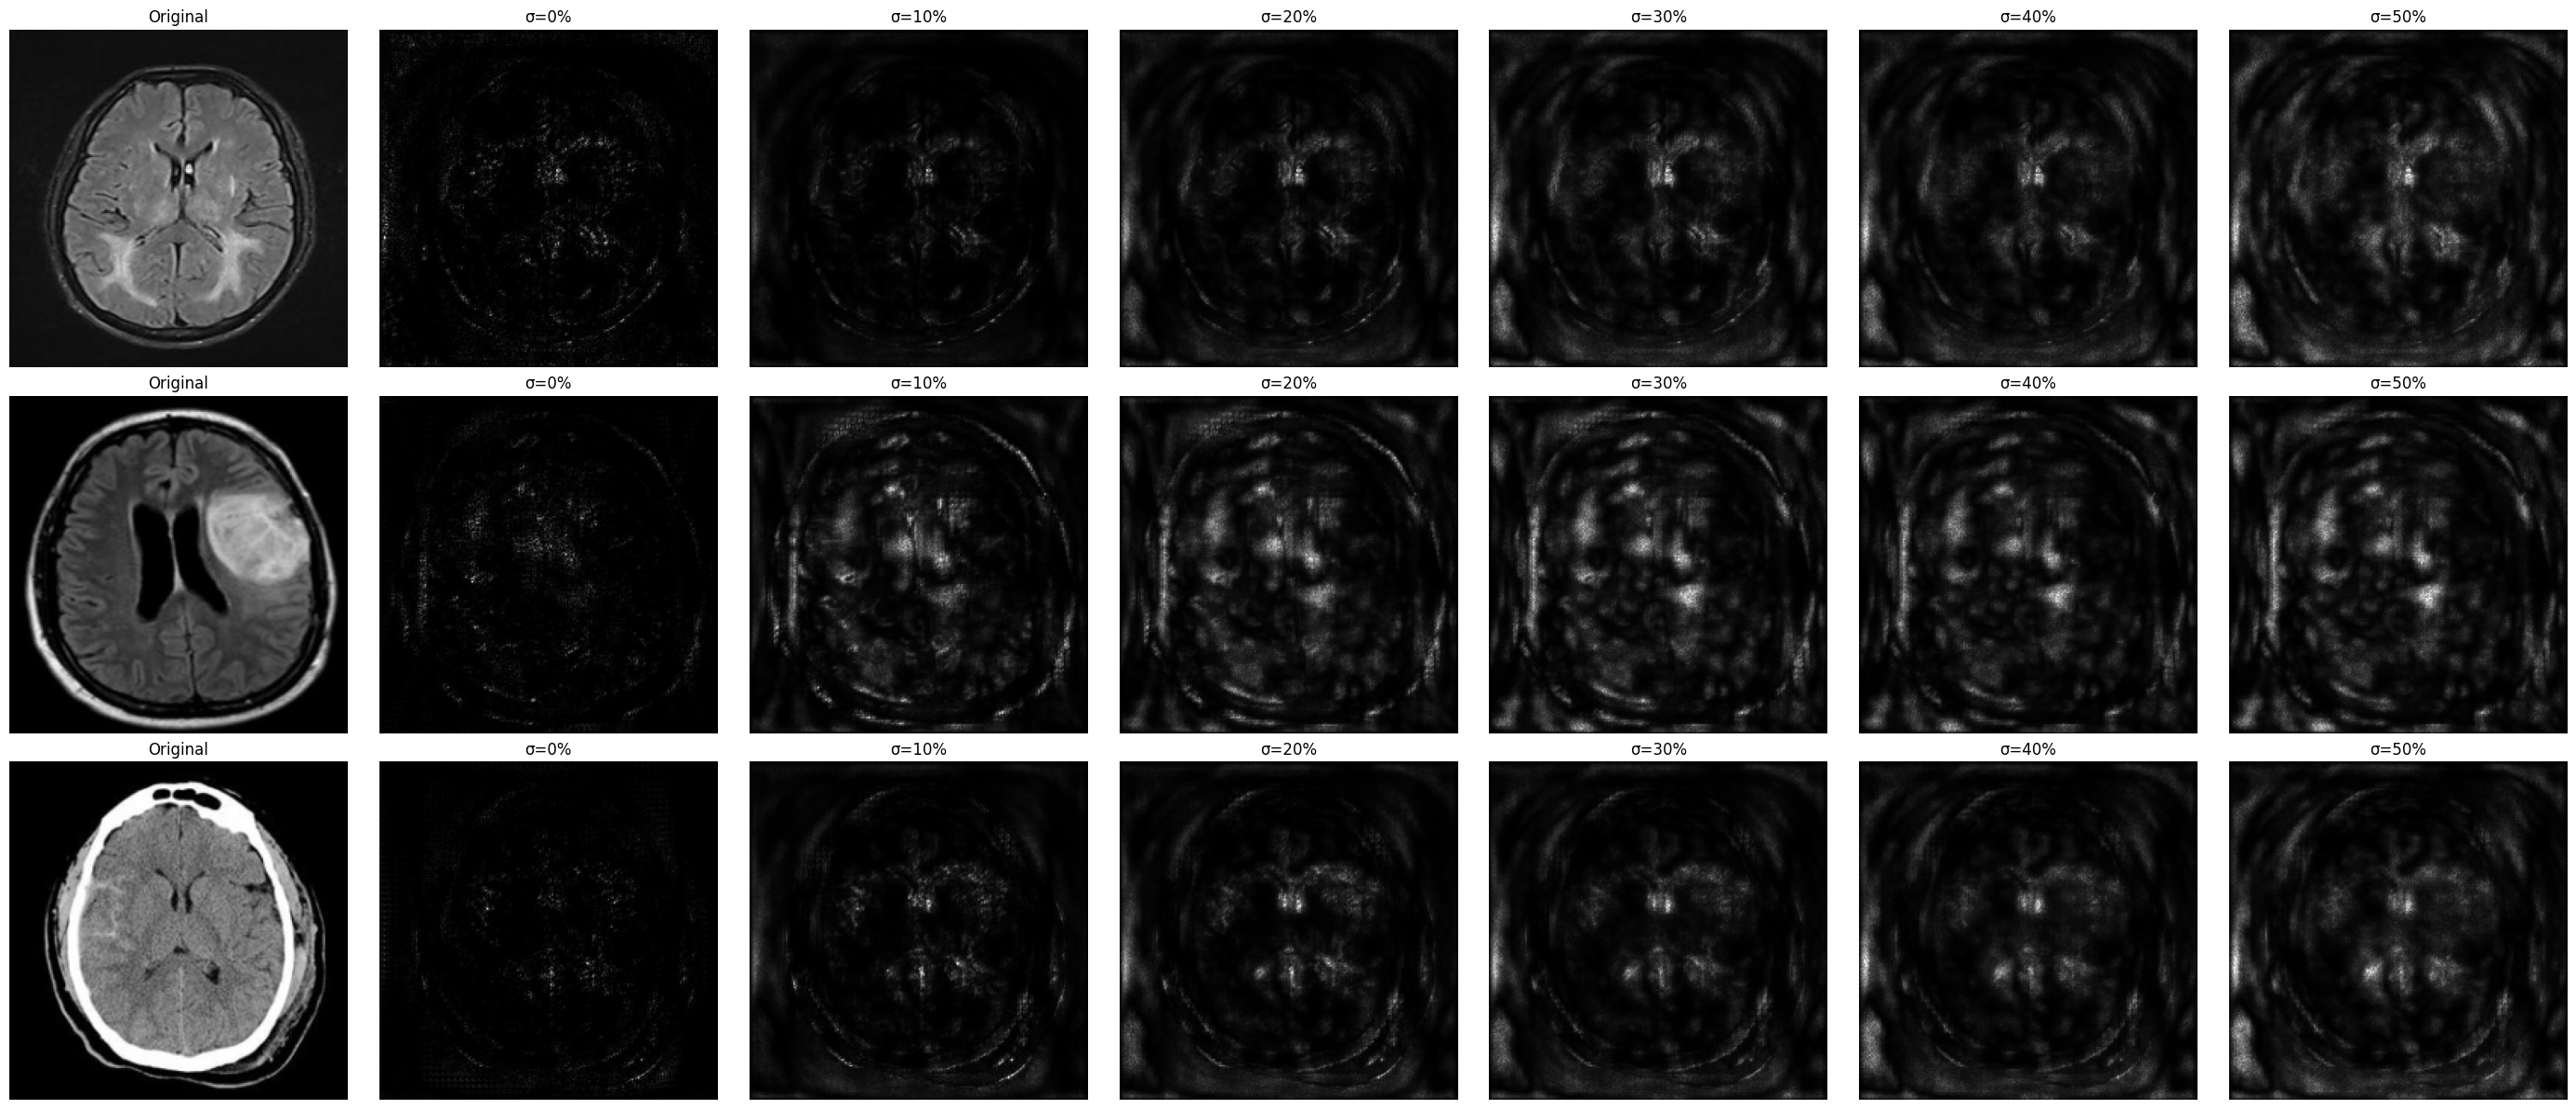

In [ ]:
import random

sigma_values = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50]

def sigma_simulations(sigma_values):
  example_imgs = []
  example_labels = []

  # choose 3 random images to compare
  # Making note of indices that show patterns:
  indices = random.sample(range(len(test_dataset)), 3)
  print(indices)

  for idx in indices:
      img, label = test_dataset[idx]
      example_imgs.append(img.unsqueeze(0))  # make shape [1,3,224,224]
      example_labels.append(label)

  all_smoothgrads = []

  for img, label in zip(example_imgs, example_labels):
      img = img.to(device)
      img_sgs = {}

      for sigma in sigma_values:

          sg_map = compute_smoothgrad(
              model, img, label, device,
              n_samples=50,
              stdev=sigma
          )

          img_sgs[sigma] = sg_map

      all_smoothgrads.append(img_sgs)

  import matplotlib.pyplot as plt

  num_imgs = len(example_imgs)
  num_sigmas = len(sigma_values)

  fig, axs = plt.subplots(num_imgs, num_sigmas+1, figsize=(4*(num_sigmas+1), 4*num_imgs))

  for row in range(num_imgs):

      original = example_imgs[row][0].permute(1,2,0).cpu().numpy()
      axs[row, 0].imshow(original)
      axs[row, 0].set_title("Original")
      axs[row, 0].axis("off")

      # Fill in SmoothGrad maps
      for col, sigma in enumerate(sigma_values, start=1):
          axs[row, col].imshow(all_smoothgrads[row][sigma], cmap='gray')
          axs[row, col].set_title(f"σ={int(sigma*100)}%")
          axs[row, col].axis("off")

  plt.tight_layout()
  plt.show()

  return None

sigma_simulations(sigma_values)


We can see from this output that at $
\sigma = 0$, there isn't much definition in our saliency map. This represents the vanilla saliency map.

As $\sigma$ increases, we can see structures more clearly, until it gets hazy as $\sigma$ passes its optimal value. This optimal value looks to be around 20%, but let's check closer.

[340, 174, 108]


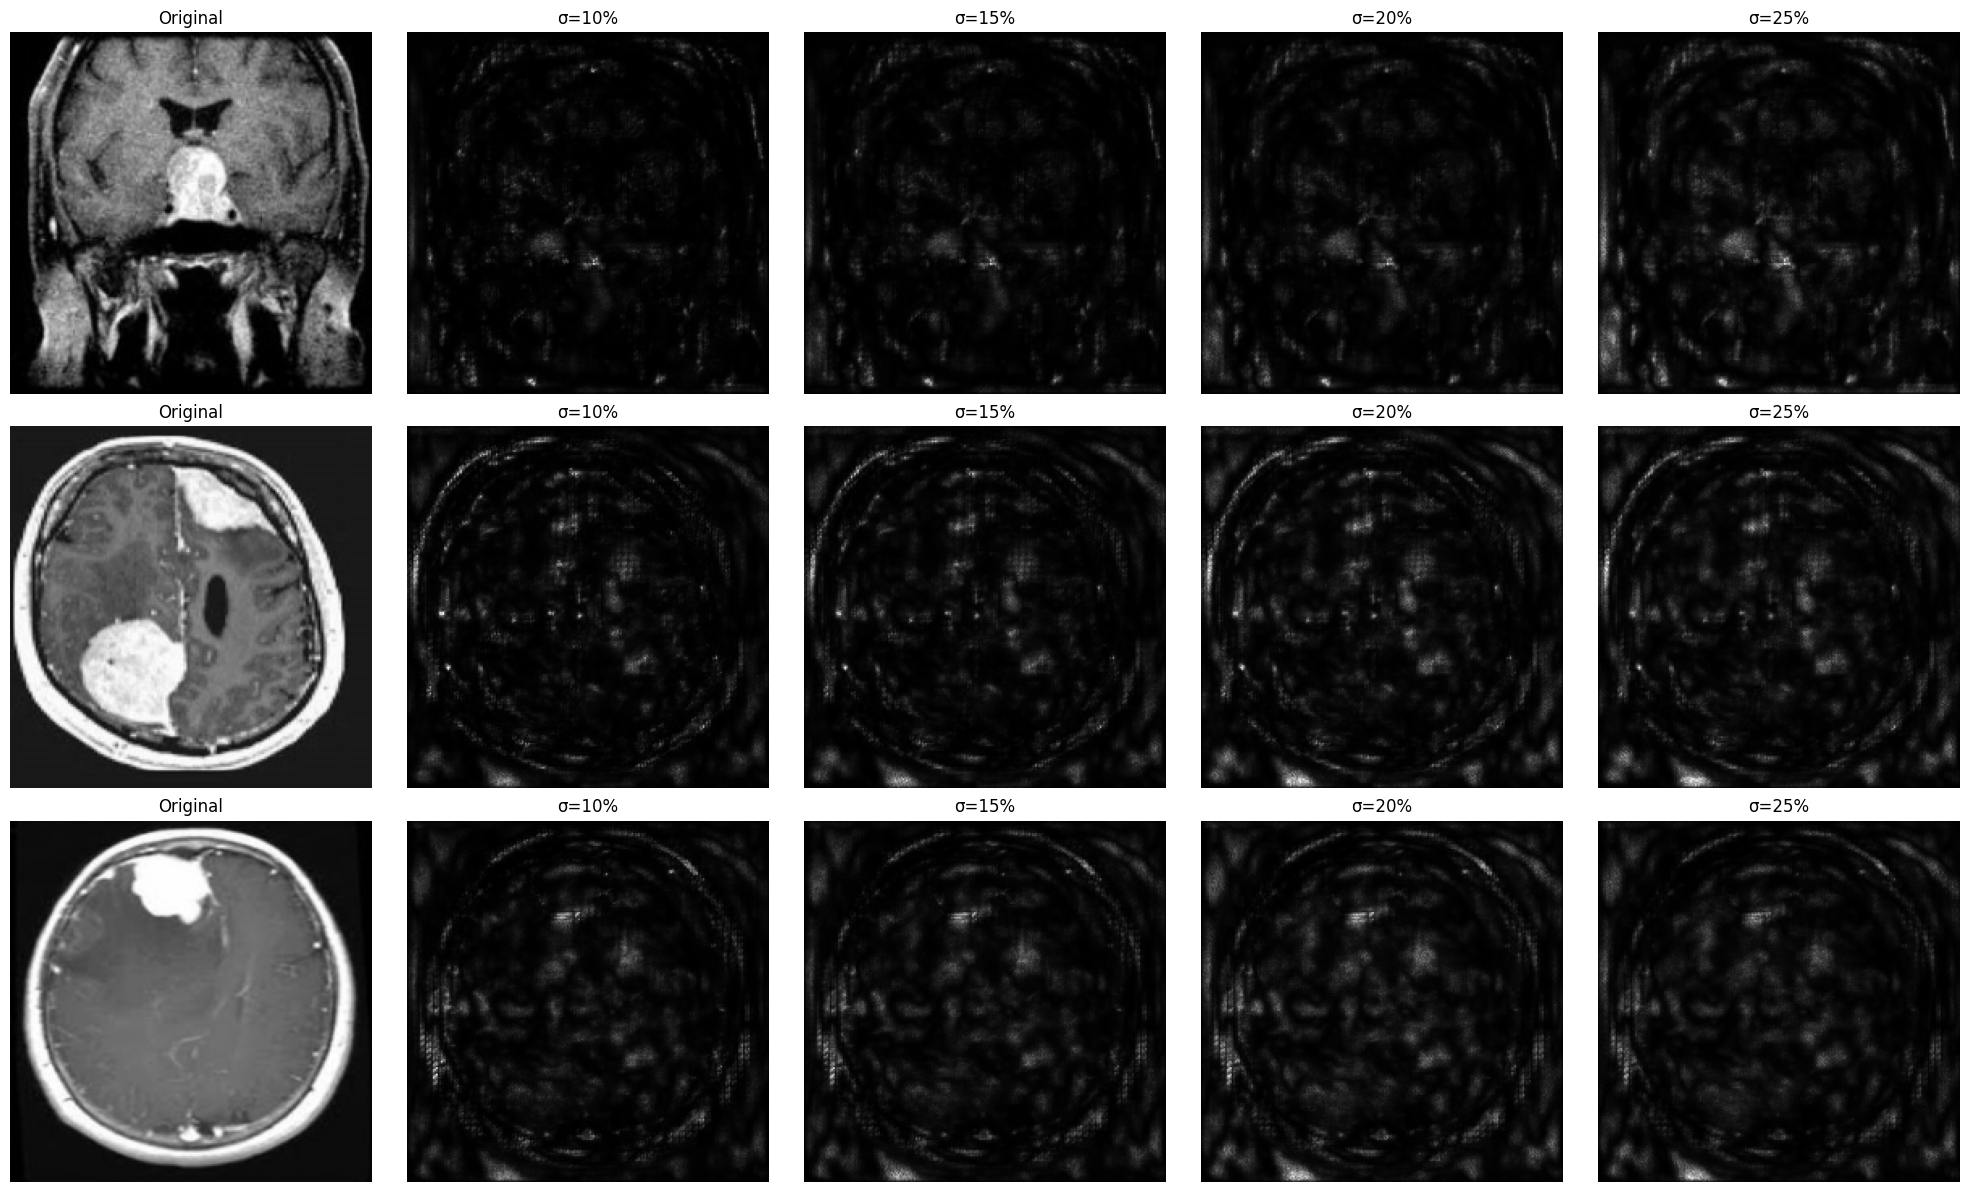

In [ ]:
sigma_values = [0.10, 0.15, 0.20, 0.25]

sigma_simulations(sigma_values)


Comparing Vanilla and SmoothGrad Saliency Maps:

In [ ]:
import matplotlib.pyplot as plt

def show_saliency_comparison(original_img, vanilla_map, smoothgrad_map):
    fig, axs = plt.subplots(1, 3, figsize=(16,5))

    axs[0].imshow(original_img, cmap='gray')
    axs[0].set_title("Original MRI")
    axs[0].axis('off')

    axs[1].imshow(vanilla_map, cmap='gray')
    axs[1].set_title("Vanilla Gradient Saliency")
    axs[1].axis('off')

    axs[2].imshow(smoothgrad_map, cmap='gray')
    axs[2].set_title("SmoothGrad Saliency")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


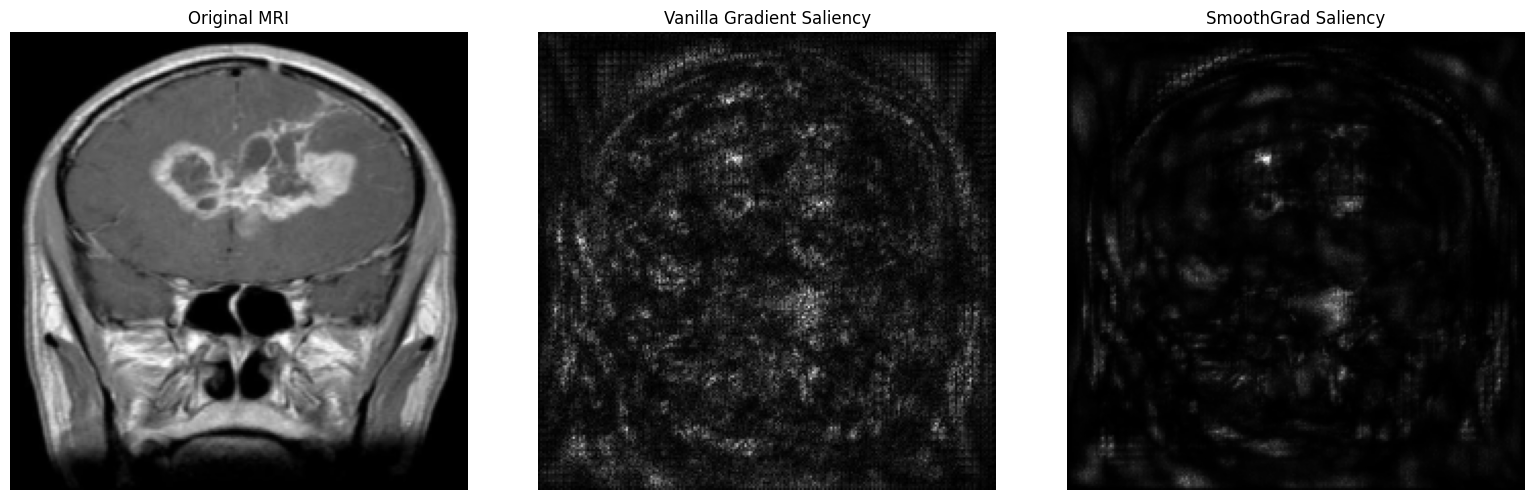

In [ ]:
# Prepare a test image
images, labels = next(iter(test_loader))

img = images[0].unsqueeze(0).to(device)   # [1,3,224,224]
target_class = labels[0].item()

# Compute saliency maps
vanilla_map = compute_vanilla_saliency(model, img, target_class, device)
smooth_map  = compute_smoothgrad(model, img, target_class, device,
                                 n_samples=50, stdev=0.15)

# Visualise
show_saliency_comparison(
    original_img = images[0].permute(1,2,0).cpu().numpy(),
    vanilla_map = vanilla_map,
    smoothgrad_map = smooth_map
)


Adding Pertubation to Investigate Robustness of Methods:

SmoothGrad improves predictive power by adding internal Gaussian noise to multiple realisations of the image and averaging across the ensemble, but what happens if we add external Gaussian noise? This is a pertubation producing a new image and demonstrates the robustness of each technique.



In [ ]:
def apply_small_perturbation(img_tensor, noise_std=0.02):
    """
    Applies a tiny Gaussian perturbation to test saliency stability.
    This noise is NOT the same as SmoothGrad's internal noise.
    """
    noise = torch.randn_like(img_tensor) * noise_std
    return img_tensor + noise


In [ ]:
import numpy as np
from scipy.stats import pearsonr

def compute_stability_metrics(map_original, map_perturbed):
    """
    Computes L2 distance and Pearson correlation between saliency maps.
    Higher correlation + lower L2 = more stable explanations.
    """
    flat_o = map_original.flatten()
    flat_p = map_perturbed.flatten()

    l2 = np.linalg.norm(flat_o - flat_p)
    corr = pearsonr(flat_o + 1e-8, flat_p + 1e-8)[0]  # numerical stability

    return l2, corr


In [ ]:
def run_stability_experiment(model, img_tensor, target_class, device, noise_std=0.02):

    # Original saliency maps
    vanilla_orig = compute_vanilla_saliency(model, img_tensor, target_class, device)
    smooth_orig  = compute_smoothgrad(model, img_tensor, target_class, device)

    # Apply external input perturbation (not SmoothGrad noise)
    img_pert = apply_small_perturbation(img_tensor, noise_std=noise_std)

    # Perturbed saliency maps
    vanilla_pert = compute_vanilla_saliency(model, img_pert, target_class, device)
    smooth_pert  = compute_smoothgrad(model, img_pert, target_class, device)

    # Compute quantitative stability
    v_l2, v_corr = compute_stability_metrics(vanilla_orig, vanilla_pert)
    s_l2, s_corr = compute_stability_metrics(smooth_orig, smooth_pert)

    return {
        "vanilla_l2": v_l2, "vanilla_corr": v_corr,
        "smooth_l2":  s_l2, "smooth_corr":  s_corr,
        "vanilla_maps": (vanilla_orig, vanilla_pert),
        "smooth_maps":  (smooth_orig, smooth_pert)
    }


In [ ]:
# Pick a random test image
idx = np.random.randint(0, len(test_dataset))
img, label = test_dataset[idx]

img_tensor = img.unsqueeze(0).to(device)
target_class = label

results = run_stability_experiment(model, img_tensor, target_class, device)


In [ ]:
print("VanillaGrad Stability:")
print("  L2 distance: ", results["vanilla_l2"])
print("  Correlation:", results["vanilla_corr"])

print("\nSmoothGrad Stability:")
print("  L2 distance: ", results["smooth_l2"])
print("  Correlation:", results["smooth_corr"])

VanillaGrad Stability:
  L2 distance:  9.2276945
  Correlation: 0.7451428

SmoothGrad Stability:
  L2 distance:  3.1760905
  Correlation: 0.9521449


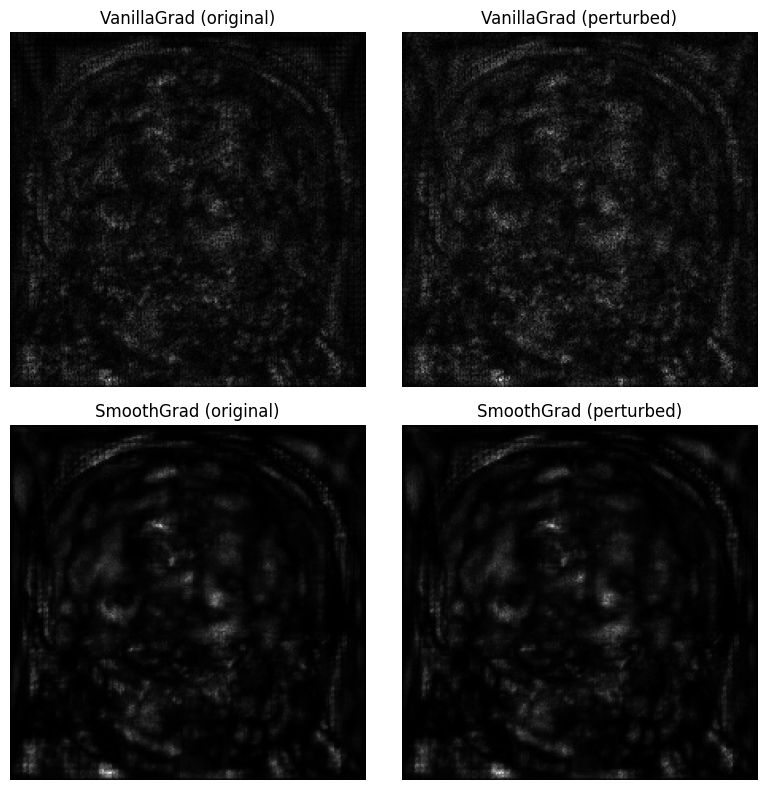

In [ ]:
vanilla_orig, vanilla_pert = results["vanilla_maps"]
smooth_orig, smooth_pert   = results["smooth_maps"]

fig, axs = plt.subplots(2, 2, figsize=(8,8))

axs[0,0].imshow(vanilla_orig, cmap="gray")
axs[0,0].set_title("VanillaGrad (original)")
axs[0,0].axis("off")

axs[0,1].imshow(vanilla_pert, cmap="gray")
axs[0,1].set_title("VanillaGrad (perturbed)")
axs[0,1].axis("off")

axs[1,0].imshow(smooth_orig, cmap="gray")
axs[1,0].set_title("SmoothGrad (original)")
axs[1,0].axis("off")

axs[1,1].imshow(smooth_pert, cmap="gray")
axs[1,1].set_title("SmoothGrad (perturbed)")
axs[1,1].axis("off")

plt.tight_layout()
plt.show()


Performance Metric:

Our performance metric is AOPC-MoRF (Most Relevant First), which measures how quickly the model's performance drops after removing the k most important pixels. This essentially measures how accurate the interpretability method was in choosing the kth most important pixels for prediction.

We denote $x^{(k)}$ as the logit score with the top $k$ salient pixels removed.

$\text{AOPC}=\frac{1}{K}\sum_{k=1}^K [R_c(x)-R_c(x^{(k)})]$




In [ ]:
import numpy as np
import torch

def perturb_top_k(img_np, saliency_map, k, baseline_value=0.0):
    """
    Remove (mask) the top-k most relevant pixels based on saliency_map.
    img_np: numpy image [H,W] or [C,H,W]
    saliency_map: numpy saliency [H,W]
    """
    img = img_np.copy()

    H, W = saliency_map.shape
    flat_sal = saliency_map.flatten()

    # indices of most relevant pixels (descending order)
    idxs = np.argsort(-flat_sal)

    # mask first k highest-attribution pixels
    mask = np.zeros_like(flat_sal, dtype=bool)
    mask[idxs[:k]] = True
    mask = mask.reshape(H, W)

    # If image has channels, broadcast mask
    if img.ndim == 3:
        for c in range(img.shape[0]):
            img[c][mask] = baseline_value
    else:
        img[mask] = baseline_value

    return img


In [ ]:
def compute_AOPC_MoRF(model, img_tensor, saliency_map, target_class, device, steps=50):
    """
    img_tensor: shape [1,3,H,W]
    saliency_map: numpy [H,W]
    steps: number of perturbations K
    """
    model.eval()

    # original score
    with torch.no_grad():
        original_score = model(img_tensor).detach()[0, target_class].item()

    # image as numpy
    img_np = img_tensor.detach().cpu().numpy()[0]   # [3,H,W]

    score_drops = []

    H, W = saliency_map.shape
    total_pixels = H * W
    pixels_per_step = total_pixels // steps

    # progressively remove top-k pixels
    for step in range(1, steps + 1):
        k = step * pixels_per_step
        perturbed_img = perturb_top_k(img_np, saliency_map, k)

        # convert back to tensor
        pert_tensor = torch.tensor(perturbed_img).unsqueeze(0).float().to(device)

        with torch.no_grad():
            new_score = model(pert_tensor).detach()[0, target_class].item()

        score_drops.append(original_score - new_score)

    # AOPC
    AOPC = np.mean(score_drops)
    return AOPC, score_drops


In [ ]:
AOPC_vanilla, drops_vanilla = compute_AOPC_MoRF(
    model, img, vanilla_map, target_class, device, steps=50
)

AOPC_smooth, drops_smooth = compute_AOPC_MoRF(
    model, img, smooth_map, target_class, device, steps=50
)

print("AOPC-MoRF (Vanilla):    ", AOPC_vanilla)
print("AOPC-MoRF (SmoothGrad): ", AOPC_smooth)


AOPC-MoRF (Vanilla):     -5.206162407472729
AOPC-MoRF (SmoothGrad):  -5.073376872614026


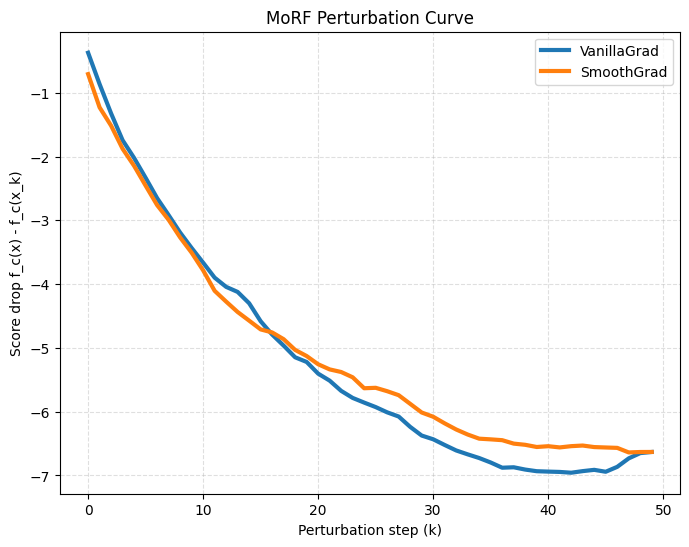

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(drops_vanilla, label="VanillaGrad", linewidth=3)
plt.plot(drops_smooth,  label="SmoothGrad", linewidth=3)

plt.xlabel("Perturbation step (k)")
plt.ylabel("Score drop f_c(x) - f_c(x_k)")
plt.title("MoRF Perturbation Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()
